In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

In [48]:
def load_application_train():
    data = pd.read_csv("diabetes.csv")
    return data

df = load_application_train()

In [50]:
#EDA
df.head()
df.describe().T
df.isnull().sum()
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [52]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]   
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


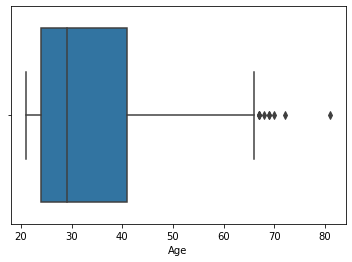

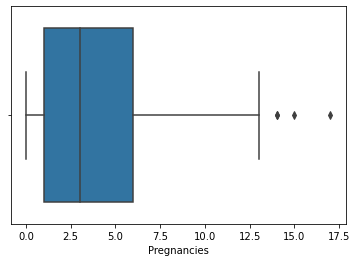

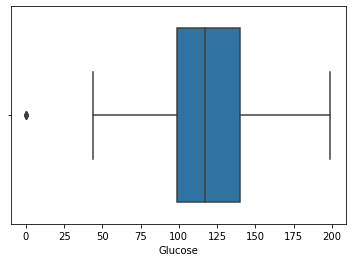

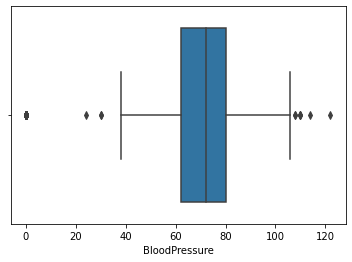

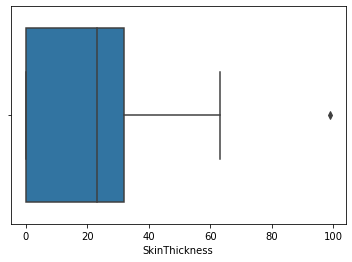

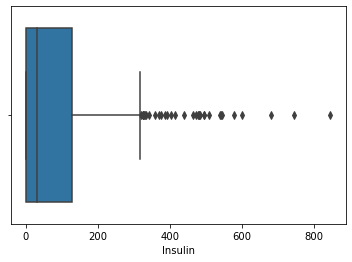

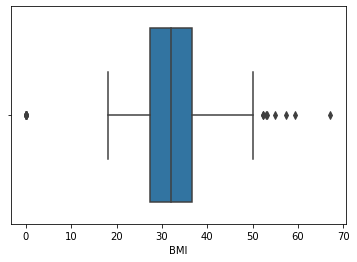

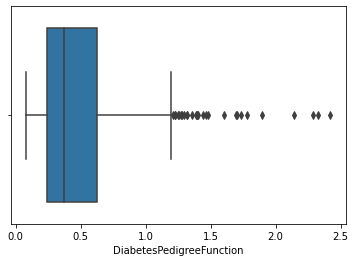

In [54]:
sns.boxplot(x=df["Age"])
plt.show()
sns.boxplot(x=df["Pregnancies"])
plt.show()
sns.boxplot(x=df["Glucose"])
plt.show()
sns.boxplot(x=df["BloodPressure"])
plt.show()
sns.boxplot(x=df["SkinThickness"])
plt.show()
sns.boxplot(x=df["Insulin"])
plt.show()
sns.boxplot(x=df["BMI"])
plt.show()
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.show()

In [55]:
for col in num_cols:
    print(col, df.groupby("Outcome").agg({col: "mean"}))

Pregnancies          Pregnancies
Outcome             
0           3.298000
1           4.865672
Glucose             Glucose
Outcome            
0        109.980000
1        141.257463
BloodPressure          BloodPressure
Outcome               
0            68.184000
1            70.824627
SkinThickness          SkinThickness
Outcome               
0            19.664000
1            22.164179
Insulin             Insulin
Outcome            
0         68.792000
1        100.335821
BMI                BMI
Outcome           
0        30.304200
1        35.142537
DiabetesPedigreeFunction          DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500
Age                Age
Outcome           
0        31.190000
1        37.067164


In [58]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    print(col, outlier_thresholds(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Pregnancies (-19.5, 32.5)
Glucose (-151.5, 404.5)
BloodPressure (-159.0, 265.0)
SkinThickness (-76.99500000000006, 128.3250000000001)
Insulin (-779.8500000000018, 1299.7500000000032)
BMI (-76.13850000000014, 126.89750000000024)
DiabetesPedigreeFunction (-2.310795, 4.103805)
Age (-48.0, 136.0)


In [60]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(df, True)
na_cols = missing_values_table(df, True)
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_cols)

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


for col in num_cols:
    print(col, grab_outliers(df, col))

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
Empty DataFrame
Columns: [n_miss, ratio]
Index: []
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Pregnancies None
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Glucose None
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
BloodPressure None
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
SkinThickness None
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Insulin None
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigre

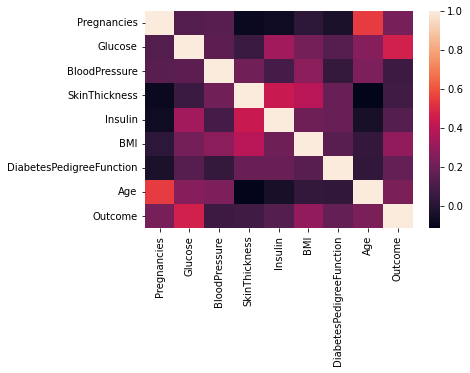

In [62]:
sns.heatmap(df.corr())
plt.show()

In [64]:
for col in df.columns:
    print(col, check_outlier(df, col))
    low, up = outlier_thresholds(df, col)
    print(low, up)
    print(df[((df[col] < low) | (df[col] > up))].shape)

Pregnancies False
-19.5 32.5
(0, 9)
Glucose False
-151.5 404.5
(0, 9)
BloodPressure False
-159.0 265.0
(0, 9)
SkinThickness False
-76.99500000000006 128.3250000000001
(0, 9)
Insulin False
-779.8500000000018 1299.7500000000032
(0, 9)
BMI False
-76.13850000000014 126.89750000000024
(0, 9)
DiabetesPedigreeFunction False
-2.310795 4.103805
(0, 9)
Age False
-48.0 136.0
(0, 9)
Outcome False
-1.5 2.5
(0, 9)


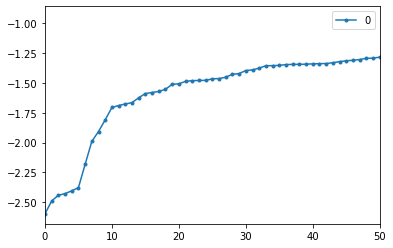

In [66]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
df_scores[0:5]
np.sort(df_scores)[0:5]

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [68]:
th = np.sort(df_scores)[6]
df[df_scores < th]
df[df_scores < th].shape
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T
df[df_scores < th].index
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)
df=df.drop(axis=0,labels=df[df_scores <th].index)
df.shape

(762, 9)

In [70]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.76
Recall: 0.685
Precision: 0.49
F1: 0.57
Auc: 0.73


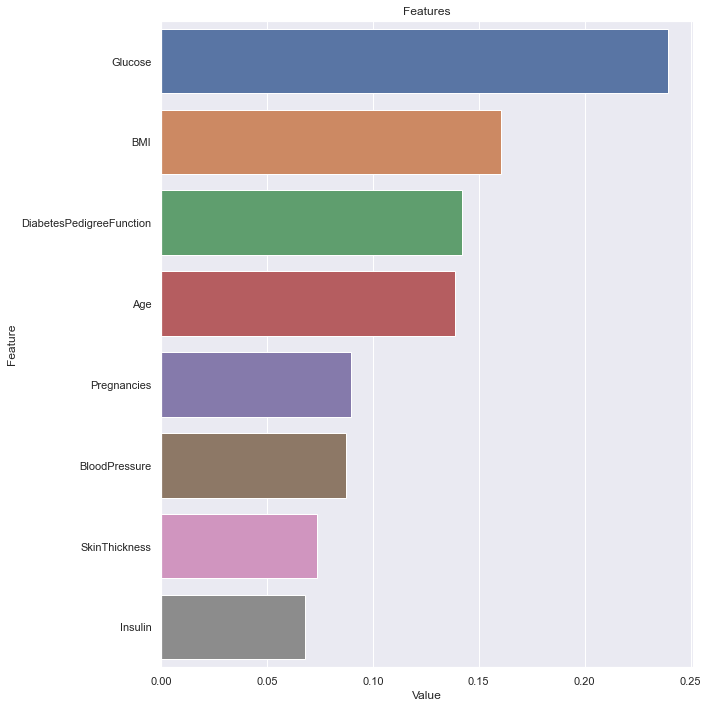

In [74]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')
plot_importance(rf_model, X)

In [77]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [80]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

df.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                     370
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [82]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           370  48.56
SkinThickness     227  29.79
BloodPressure      35   4.59
BMI                11   1.44


In [85]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[ :,temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
missing_vs_target(df, "Outcome", na_columns)

                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                         0.342503    727
1                         0.457143     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                         0.330841    535
1                         0.387665    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                   0.329082    392
1                   0.367568    370


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0               0.350200    751
1               0.181818     11




In [88]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [91]:
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.9):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
check_outlier(df, "SkinThickness")
check_outlier(df, "BMI")

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction True
Age False
Outcome False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction True
Age False
Outcome False


In [94]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])

df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"


df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"


df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]


In [97]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6,148,72.0,35.0,125.0,33.6,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.0
1,1,85,66.0,29.0,125.0,26.6,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.0
2,8,183,64.0,29.0,125.0,23.3,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.0
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.0


In [100]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 762
Variables: 16
cat_cols: 7
num_cols: 9
cat_but_car: 0
num_but_cat: 3


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_AGE_CAT,NEW_INSULIN_SCORE,...,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,Outcome_1,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148,72.0,35.0,125.0,33.6,0.627,50,1,1,...,0,0,0,0,1,0,0,1,1,0
1,1,85,66.0,29.0,125.0,26.6,0.351,31,0,1,...,0,0,1,0,0,0,1,0,0,0
2,8,183,64.0,29.0,125.0,23.3,0.672,32,0,1,...,0,0,0,0,1,1,0,0,1,0
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0,1,...,0,0,1,0,0,0,1,0,0,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,0,0,...,0,0,0,0,1,0,0,1,0,0


In [108]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [112]:
y = df["Outcome_1"]
X = df.drop("Outcome_1", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.75
Recall: 0.636
Precision: 0.55
F1: 0.59
Auc: 0.71


       Value                            Feature
1   0.141702                            Glucose
10  0.135699                NEW_GLUCOSE*INSULIN
6   0.116153           DiabetesPedigreeFunction
5   0.103700                                BMI
7   0.094801                                Age
0   0.071975                        Pregnancies
2   0.065408                      BloodPressure
3   0.063004                      SkinThickness
4   0.051259                            Insulin
23  0.046417            NEW_GLUCOSE_Prediabetes
14  0.026039     NEW_AGE_GLUCOSE_NOM_highmature
22  0.020685                      NEW_BMI_Obese
18  0.020261   NEW_AGE_GLUCOSE_NOM_normalmature
21  0.013208                 NEW_BMI_Overweight
20  0.006330                    NEW_BMI_Healthy
9   0.006224                  NEW_INSULIN_SCORE
11  0.005344        NEW_AGE_BMI_NOM_obesesenior
8   0.004650                        NEW_AGE_CAT
15  0.003997     NEW_AGE_GLUCOSE_NOM_highsenior
13  0.002678   NEW_AGE_GLUCOSE_NOM_hidde

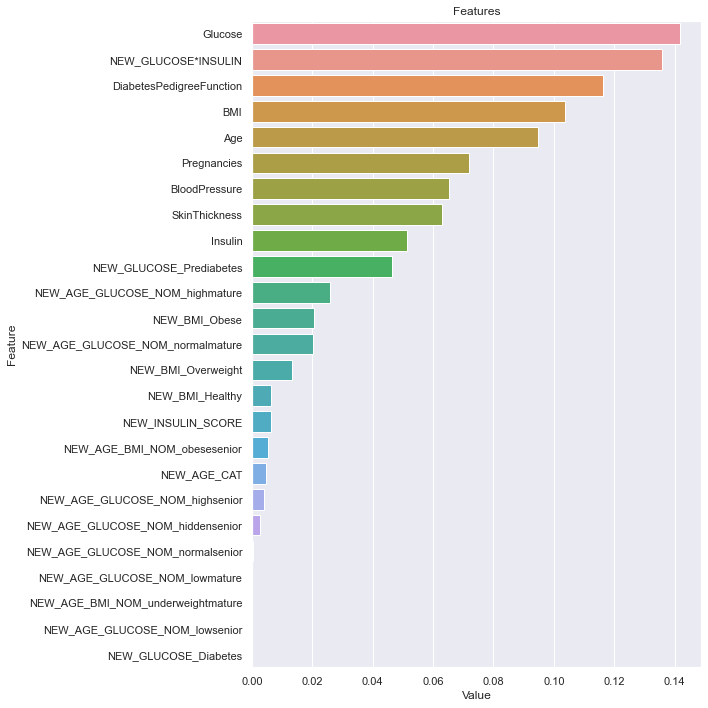

In [118]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)